### Data preprocessing of LinkedIn Job Postings Dataset
#### Setup and Library Installation

In [ ]:
# %pip install pandas
# %pip install seaborn
# %pip install matplotlib
# %pip install scipy
# %pip install sklearn
# %pip install imbalanced-learn 

#### Library Imports



In [7]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

#### Loading Data

In [64]:
# Load datasets from the CSV files for analysis.
job_postings = pd.read_csv('data/job_postings.csv')
job_skills = pd.read_csv('data/job_details/job_skills.csv')

companies = pd.read_csv('data/company_details/companies.csv')
mapping_skills = pd.read_csv('data/maps/skills.csv')

#### Dataset summary

In [65]:
unique_values = {
    'job_postings': job_postings['job_id'].nunique(), # details of job postings
    'job_skills': job_skills['job_id'].nunique(), # job posting with the required skill abbreviated
    'companies': companies['company_id'].nunique(), # information on the company
    'skills': mapping_skills['skill_name'].nunique() # maps between skill abbreviations and full skill names
    }
unique_values

{'job_postings': 33246, 'job_skills': 32422, 'companies': 11361, 'skills': 35}

#### Handling the integration of job_skills with mapping_skills
Merging job_skills with mapping_skills

In [66]:
# Merging job_skills with mapping_skills to replace skill_abr with skill_name
merged_skills = pd.merge(job_skills, mapping_skills, on='skill_abr', how='left')
merged_skills = merged_skills.drop('skill_abr', axis=1)
merged_skills.head()

,job_id,skill_name
0,3690843087,Accounting/Auditing
1,3690843087,Finance
2,3691763971,Management
3,3691763971,Manufacturing
4,3691775263,Management


In [67]:
merged_skills.shape

(56591, 2)

Aggregating Skills by Job ID

In [68]:
# Aggregation process is done to handle duplicate 'job_id's resulting from multiple skills per job:

# Grouping by 'job_id' and concatenating 'skill_name' values
grouped_skills = merged_skills.groupby('job_id')['skill_name'].agg(lambda x: ', '.join(x)).reset_index()

# Display the resulting DataFrame with unique 'job_id' rows and concatenated skills
print(grouped_skills)

           job_id                                    skill_name
0         3958427  Design, Art/Creative, Information Technology
1        85008768                   Sales, Business Development
2       102339515                   Business Development, Sales
3       108965123                                Administrative
4       133114754                   Sales, Business Development
...           ...                                           ...
32417  3757937095                        Information Technology
32418  3757938018                     Management, Manufacturing
32419  3757938019                                   Engineering
32420  3757940025                     Management, Manufacturing
32421  3757940104                                         Other

[32422 rows x 2 columns]


#### Handling the integration of job_postings with grouped_skills
Checking for missing data in Company ID's

In [69]:
missing_id = job_postings['company_id'].isnull().sum()
missing_id

654

Dropping rows with empty company_id's

In [70]:
# Shape of dataset before removing missing values
job_postings.shape

(33246, 28)

In [15]:
# Inplace = True operation will modify the DataFrame job_postings in place, and the changes will be applied directly to it 
# without the need to reassign the result to a new variable.
job_postings.dropna(subset=['company_id'], inplace=True)
job_postings.shape

(32592, 28)

In [71]:
missing_id = job_postings['company_id'].isnull().sum()
missing_id

654

Merging job_postings with grouped_skills

In [72]:
merged_job_postings_skills = pd.merge(job_postings, grouped_skills, on='job_id', how='left')

Converting company data type to int from float

In [74]:
# Because there used to be missing values in company id's, NaN was considered as float value, therefore all data in the column was converted
# to float from int
if 'company_id' in merged_job_postings_skills.columns:
    merged_job_postings_skills['company_id'] = merged_job_postings_skills['company_id'].astype('Int64')

In [75]:
merged_job_postings_skills.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped,skill_name
0,3757940104,553718,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",...,Entry level,NaN,1.699090e+12,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101,Other
1,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",...,NaN,NaN,1.699080e+12,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085420,"Management, Manufacturing"
2,3757938019,474443,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",...,NaN,Bachelor's Degree in Mechanical Engineering pr...,1.699080e+12,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085644,Engineering
3,3757938018,18213359,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,Entry level,NaN,1.699080e+12,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461,"Management, Manufacturing"
4,3757937095,437225,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,...,Mid-Senior level,NaN,1.699090e+12,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346,Information Technology


Reducing dimensionality of merged_job_postings_skills by dropping unnecessary columns

In [76]:
columns_to_drop = ['description', 'max_salary','med_salary','min_salary',
                   'pay_period', 'applies', 'formatted_work_type', 'remote_allowed',
                   'job_posting_url','views','title','application_url','application_type',
                   'expiry','skills_desc','posting_domain','sponsored','original_listed_time',
                   'work_type','currency','compensation_type','scraped','closed_time','listed_time'
                   ]
merged_job_postings_skills= merged_job_postings_skills.drop(columns=columns_to_drop,axis=1)
merged_job_postings_skills.head()


,job_id,company_id,location,formatted_experience_level,skill_name
0,3757940104,553718,"Little River, SC",Entry level,Other
1,3757940025,2192142,"Beaver Dam, WI",NaN,"Management, Manufacturing"
2,3757938019,474443,"Bessemer, AL",NaN,Engineering
3,3757938018,18213359,"Aliso Viejo, CA",Entry level,"Management, Manufacturing"
4,3757937095,437225,United States,Mid-Senior level,Information Technology


#### Handling the integration of merged_job_postings_skills with companies
Merging merged_job_postings_skills with companies


In [77]:
merged_data= pd.merge(merged_job_postings_skills, companies, on='company_id', how='left')
merged_data.head()

,job_id,company_id,location,formatted_experience_level,skill_name,name,description,company_size,state,country,city,zip_code,address,url
0,3757940104,553718,"Little River, SC",Entry level,Other,HearingLife,HearingLife is a national hearing care company...,5.0,New Jersey,US,Somerset,08873,580 Howard Avenue,https://www.linkedin.com/company/hearing-life
1,3757940025,2192142,"Beaver Dam, WI",NaN,"Management, Manufacturing","Metalcraft of Mayville, Inc.","Headquartered in Mayville, Wisconsin, Metalcra...",4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...
2,3757938019,474443,"Bessemer, AL",NaN,Engineering,"U.S. Tsubaki Power Transmission, LLC","U.S. Tsubaki Power Transmission, LLC is a subs...",4.0,Illinois,US,Wheeling,60090,301E Marquardt Drive,https://www.linkedin.com/company/u.s.-tsubaki-...
3,3757938018,18213359,"Aliso Viejo, CA",Entry level,"Management, Manufacturing",Episcopal Communities & Services,Episcopal Communities & Services (ECS) has bec...,4.0,California,US,Altadena,91001,2212 El Molino Ave,https://www.linkedin.com/company/episcopal-com...
4,3757937095,437225,United States,Mid-Senior level,Information Technology,"iHerb, LLC",iHerb is on a mission to make health and welln...,5.0,California,US,Irvine,92618,17400 Laguna Canyon Rd,https://www.linkedin.com/company/iherb


Reducing dimensionality by dropping unnecessary columns

In [78]:
columns_to_drop = ['description','company_size','zip_code','url','address','state','city']
merged_data= merged_data.drop(columns=columns_to_drop,axis=1)
merged_data.head()

,job_id,company_id,location,formatted_experience_level,skill_name,name,country
0,3757940104,553718,"Little River, SC",Entry level,Other,HearingLife,US
1,3757940025,2192142,"Beaver Dam, WI",NaN,"Management, Manufacturing","Metalcraft of Mayville, Inc.",US
2,3757938019,474443,"Bessemer, AL",NaN,Engineering,"U.S. Tsubaki Power Transmission, LLC",US
3,3757938018,18213359,"Aliso Viejo, CA",Entry level,"Management, Manufacturing",Episcopal Communities & Services,US
4,3757937095,437225,United States,Mid-Senior level,Information Technology,"iHerb, LLC",US


Displaying data in a better order

In [79]:
column_order = ['job_id','company_id','name','location','country','skill_name','formatted_experience_level']
merged_data = merged_data[column_order]
merged_data.head()

,job_id,company_id,name,location,country,skill_name,formatted_experience_level
0,3757940104,553718,HearingLife,"Little River, SC",US,Other,Entry level
1,3757940025,2192142,"Metalcraft of Mayville, Inc.","Beaver Dam, WI",US,"Management, Manufacturing",NaN
2,3757938019,474443,"U.S. Tsubaki Power Transmission, LLC","Bessemer, AL",US,Engineering,NaN
3,3757938018,18213359,Episcopal Communities & Services,"Aliso Viejo, CA",US,"Management, Manufacturing",Entry level
4,3757937095,437225,"iHerb, LLC",United States,US,Information Technology,Mid-Senior level


#### Identify remaining missing data in the merged dataset
Display columns with significant missing data

In [80]:
missing_data = merged_data.isnull().sum()
significant_missing_columns = missing_data[missing_data > 0].sort_values(ascending=True)
significant_missing_columns

company_id                     654
country                        701
name                           705
skill_name                    1212
formatted_experience_level    9181
dtype: int64

Handling missing values of 'name' column

In [81]:
# After merging, 51 rows of company references in job_postings were non existent in the company id's dataset. 
missing_names = merged_data['name'].isnull().sum()

null_name_indices = merged_data[merged_data['name'].isnull()]['company_id']
print("Number of missing ID's:", missing_names)
print(null_name_indices)

Number of missing ID's: 705
37       <NA>
50       <NA>
63       <NA>
74       <NA>
76       <NA>
         ... 
33231    <NA>
33232    <NA>
33239    <NA>
33242    <NA>
33244    <NA>
Name: company_id, Length: 705, dtype: Int64


In [82]:
merged_data.to_csv('data_preprocessed/merged_data.csv', index=False)

Dropping columns where name is null

In [83]:
# 'name' of companies that did not exist in companies.csv, but did in job_postings.csv, are null
merged_data.dropna(subset=['name'], inplace=True)

Handling missing values of 'skill_name' column

In [84]:
# Handling missing values of 'skill_name' column
col_skill_fill_other = ['skill_name']
for col in col_skill_fill_other:
    merged_data[col].fillna("Other", inplace=True)

Handling missing values of 'formatted_experience_level' column

In [85]:
# Categorical columns with missing values are filled with "Not Specified"
col_experience_fill_not_specified = ['formatted_experience_level']
for col in col_experience_fill_not_specified:
    merged_data[col].fillna("Not Specified", inplace=True)


Check for remaining missing values

In [86]:
remaining_missing = merged_data.isnull().sum()
remaining_missing_cols = remaining_missing[remaining_missing > 0].sort_values(ascending=False)
remaining_missing_cols

Series([], dtype: int64)

#### Categorizing experience level

In [87]:
# Data Transformation
experience_levels = merged_data['formatted_experience_level'].unique()

for value in experience_levels:
    print(value)


Entry level
Not Specified
Mid-Senior level
Director
Associate
Executive
Internship


Mapping experience to their numeric new values

In [88]:
experience_mapping = {
    'Internship': 1,
    'Entry level': 2,
    'Associate':3, 
    'Mid-Senior level': 4,
    'Director': 5,
    'Executive': 6,
    'Not Specified': 7
}

merged_data['formatted_experience_level'] = merged_data['formatted_experience_level'].map(experience_mapping)

#### Cleaning data in 'name' attribute

In [89]:
def clean_company_names(name):

    # Remove special characters, except spaces and dots
    name = re.sub(r'[^a-zA-Z0-9\w\s\.]', '', name)

    # Remove extra spaces
    name = re.sub(r'\s+', ' ', name).strip()

    # Handle hyphens and apostrophes
    name = name.replace('-', ' ')  # Replace hyphens with spaces
    name = name.replace('\'', '')  # Remove apostrophes
    name = re.sub(r'\s+', ' ', name)

    return name

merged_data['name'] = merged_data['name'].apply(clean_company_names)

#### Extract City from 'location' attribute

In [90]:
def extract_city(location):
    words = location.split()
    if len(words) == 1:  # Check if the location has only one word
        return None
    parts = location.split(', ')
    if len(parts) > 1:  # Check if the format is City, State, 
        return parts[0]
    else:
        if "Metropolitan Area" in location:
            return location.split(" Metropolitan Area")[0]
        elif "Area" in location or "Greater" in location:
            return location
        else:
            return None

# Apply the function to the 'location' column
merged_data['location'] = merged_data['location'].apply(extract_city)
merged_data.shape

(32541, 7)

In [91]:
remaining_missing = merged_data['location'].isnull().sum()
remaining_missing

2366

In [92]:
merged_data = merged_data.dropna(subset=['location'])
merged_data.shape

(30175, 7)

#### Preprocessed Dataset

Shape of the cleaned data

In [93]:
merged_data_cleaned = merged_data
merged_data_cleaned.shape

(30175, 7)

Rename column names 

In [94]:

merged_data_cleaned = merged_data_cleaned.rename(columns={'name':'company','skill_name':'required_skill',
                                                           'formatted_experience_level':'experience_level'})

merged_data_cleaned = merged_data_cleaned.sort_values('job_id', ascending=False)



Display

In [95]:
merged_data_cleaned

,job_id,company_id,company,location,country,required_skill,experience_level
0,3757940104,553718,HearingLife,Little River,US,Other,2
1,3757940025,2192142,Metalcraft of Mayville Inc.,Beaver Dam,US,"Management, Manufacturing",7
2,3757938019,474443,U.S. Tsubaki Power Transmission LLC,Bessemer,US,Engineering,7
3,3757938018,18213359,Episcopal Communities Services,Aliso Viejo,US,"Management, Manufacturing",2
6,3757937004,10515052,Boyd Group Services Inc.,Daytona Beach,CA,"Management, Manufacturing",2
...,...,...,...,...,...,...,...
33238,381055942,96654609,First Baptist Church Forney,Forney,US,Other,7
33240,133196985,1089558,Employvision Inc.,New York,US,"Accounting/Auditing, Finance",7
33241,133114754,77766802,CargoLogin.,Santa Clarita,US,"Sales, Business Development",7
33243,102339515,52132271,DryerVentz DuctVentz,Greater Boston,US,"Business Development, Sales",7


Save the preprocessed dataset to data_preprocessed.csv

In [96]:
merged_data_cleaned.to_csv('data_preprocessed/job_postings.csv', index=False)

### Detecting Outliers

Checking for outliers in Experience Level

In [97]:
merged_data_cleaned['Z_Score'] = np.abs(stats.zscore(merged_data_cleaned['experience_level'], nan_policy='omit'))
threshold = 3
outliers_z = merged_data_cleaned[merged_data_cleaned['Z_Score'] > threshold]
print("Outliers identified by Z-Score method:")
print(outliers_z.head())

Outliers identified by Z-Score method:
Empty DataFrame
Columns: [job_id, company_id, company, location, country, required_skill, experience_level, Z_Score]
Index: []


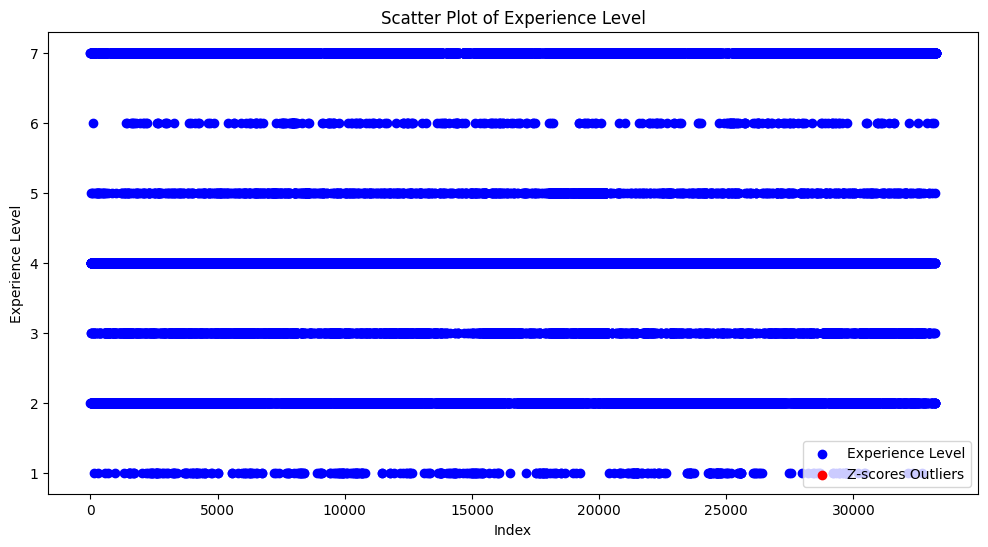

In [98]:
plt.figure(figsize=(12, 6))
plt.scatter(merged_data_cleaned.index, merged_data_cleaned['experience_level'], color='blue', label='Experience Level')

# Scatter plot for outliers
plt.scatter(outliers_z.index, outliers_z['experience_level'], color='red', label='Z-scores Outliers')
plt.title("Scatter Plot of Experience Level")
plt.xlabel("Index")
plt.ylabel("Experience Level")
plt.legend()
plt.show()

In [107]:
company_country = merged_data_cleaned['country'].unique()
company_country


array(['US', 'CA', 'FR', 'GB', '0', 'NL', 'DK', 'LI', 'JP', 'CH', 'BE',
       'SE', 'IN', 'AU', 'CN', 'DE', 'ES', 'KR', 'MT', 'IE', 'IL', 'OO',
       'IT', 'LU', 'EE', 'AT', 'BM', 'FI', 'ID', 'AE', 'AZ', 'IS', 'TW',
       'MX', 'SG', 'NO', 'HK', 'NZ', 'RU', 'BR', 'KE', 'SA', 'TR', 'GE',
       'HU', 'PR', 'UY', 'CO', 'CZ', 'AR', 'PH', 'MD'], dtype=object)

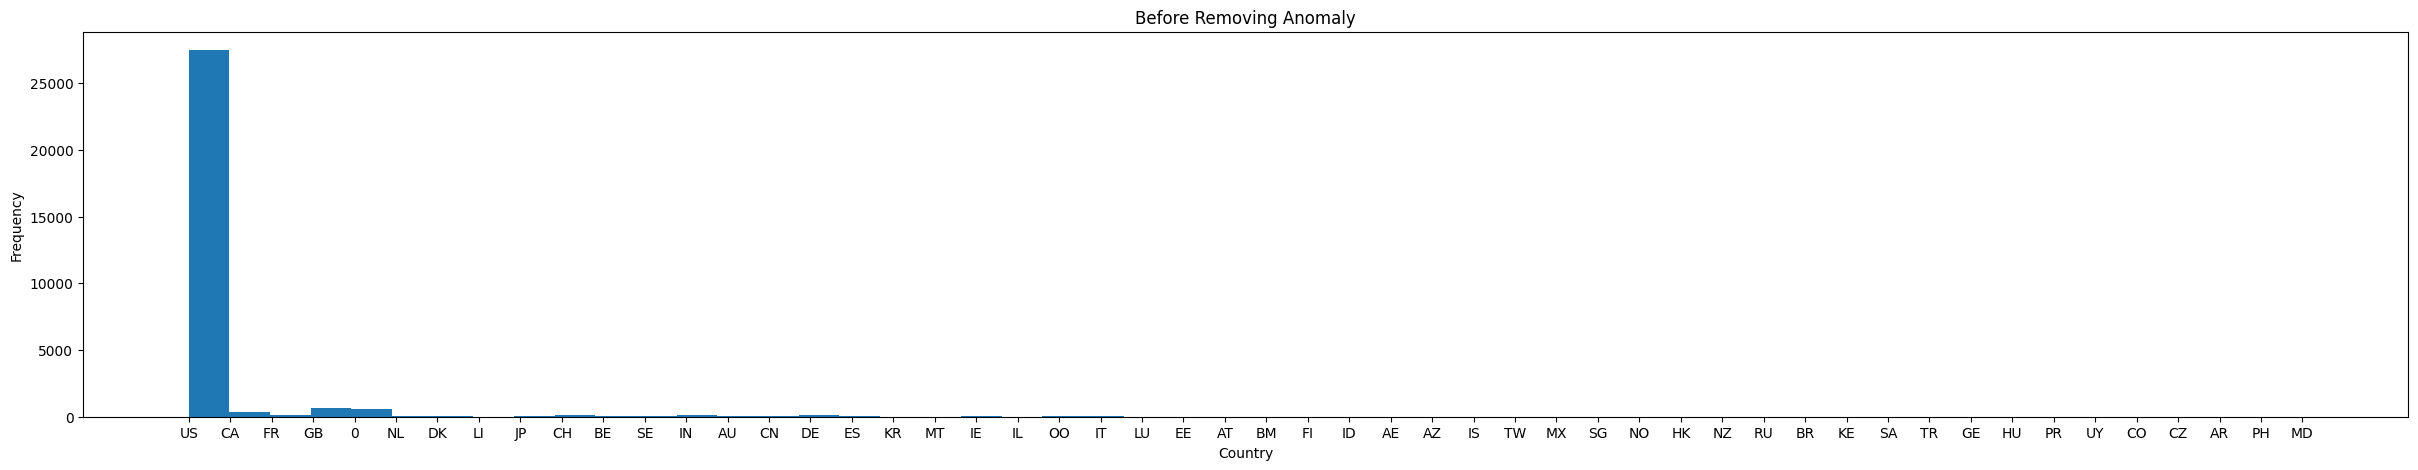

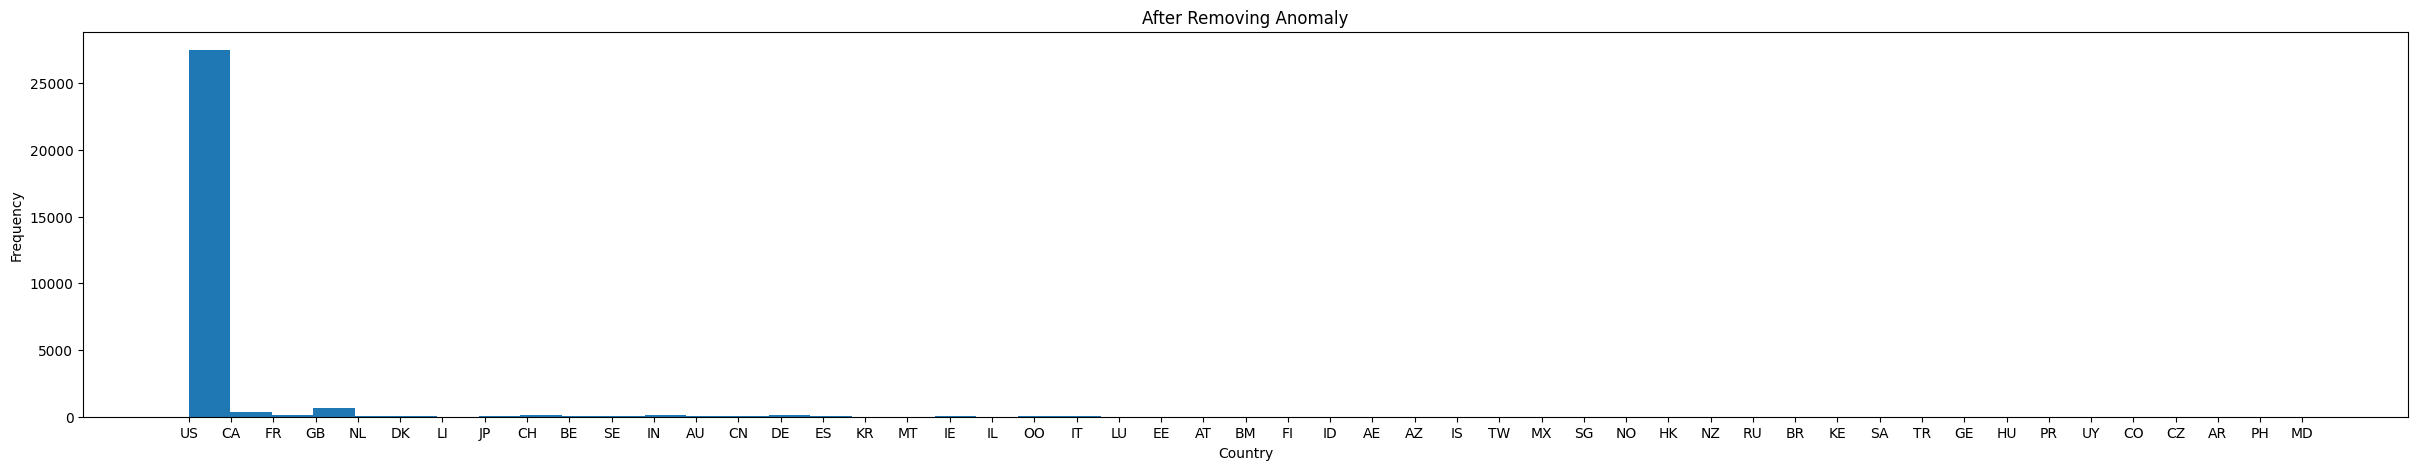

DataFrame after removing anomalies:
           job_id  company_id                              company  \
0      3757940104      553718                          HearingLife   
1      3757940025     2192142          Metalcraft of Mayville Inc.   
2      3757938019      474443  U.S. Tsubaki Power Transmission LLC   
3      3757938018    18213359       Episcopal Communities Services   
6      3757937004    10515052             Boyd Group Services Inc.   
...           ...         ...                                  ...   
33238   381055942    96654609          First Baptist Church Forney   
33240   133196985     1089558                    Employvision Inc.   
33241   133114754    77766802                          CargoLogin.   
33243   102339515    52132271                 DryerVentz DuctVentz   
33245     3958427      630152                    Karen Marie Salon   

             location country                                required_skill  \
0        Little River      US               

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to generate valid_countries dynamically based on length criteria
def generate_valid_countries(merged_data_cleaned):
    return list(merged_data_cleaned[merged_data_cleaned['country'].apply(len) == 2]['country'].unique())

# Generate valid_countries list dynamically
valid_countries = generate_valid_countries(merged_data_cleaned)

# Function to identify anomalies based on domain-specific knowledge
def remove_country_anomalies(merged_data_cleaned, valid_countries):
    return merged_data_cleaned[merged_data_cleaned['country'].isin(valid_countries)]

# Visualize data before removing anomalies
plt.figure(figsize=(30, 5))
plt.hist(merged_data_cleaned['country'], bins=len(merged_data_cleaned['country'].unique()))
plt.title('Before Removing Anomaly')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.show()

# Detect and remove anomalies based on domain-specific knowledge
cleaned_df = remove_country_anomalies(merged_data_cleaned, valid_countries)

# Visualize data after removing anomalies
plt.figure(figsize=(30, 5))
plt.hist(cleaned_df['country'], bins=len(cleaned_df['country'].unique()))
plt.title('After Removing Anomaly')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.show()

# Display the cleaned DataFrame
print("DataFrame after removing anomalies:")
print(cleaned_df)

In [118]:
count_anomalies = (cleaned_df['country'] == '0').sum()

print("Number of anomalies in the 'country' column:", count_anomalies)

Number of anomalies in the 'country' column: 0


In [120]:
def generate_country_mapping(countries):
    country_mapping = {country: index + 1 for index, country in enumerate(countries)}
    return country_mapping

# Example input array
input_countries = cleaned_df['country'].unique()

# Generate the mapping using the function
country_mapping = generate_country_mapping(input_countries)

# Display the resulting mapping
print(country_mapping)

{'US': 1, 'CA': 2, 'FR': 3, 'GB': 4, 'NL': 5, 'DK': 6, 'LI': 7, 'JP': 8, 'CH': 9, 'BE': 10, 'SE': 11, 'IN': 12, 'AU': 13, 'CN': 14, 'DE': 15, 'ES': 16, 'KR': 17, 'MT': 18, 'IE': 19, 'IL': 20, 'OO': 21, 'IT': 22, 'LU': 23, 'EE': 24, 'AT': 25, 'BM': 26, 'FI': 27, 'ID': 28, 'AE': 29, 'AZ': 30, 'IS': 31, 'TW': 32, 'MX': 33, 'SG': 34, 'NO': 35, 'HK': 36, 'NZ': 37, 'RU': 38, 'BR': 39, 'KE': 40, 'SA': 41, 'TR': 42, 'GE': 43, 'HU': 44, 'PR': 45, 'UY': 46, 'CO': 47, 'CZ': 48, 'AR': 49, 'PH': 50, 'MD': 51}


In [121]:

cleaned_df['country'] = cleaned_df['country'].map(country_mapping)

C:\Users\Blina Smailaj\AppData\Local\Temp\ipykernel_30052\3568562196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['country'] = cleaned_df['country'].map(country_mapping)


In [122]:
cleaned_df.head()

,job_id,company_id,company,location,country,required_skill,experience_level,Z_Score,country_length
0,3757940104,553718,HearingLife,Little River,1,Other,2,1.158713,2
1,3757940025,2192142,Metalcraft of Mayville Inc.,Beaver Dam,1,"Management, Manufacturing",7,1.490970,2
2,3757938019,474443,U.S. Tsubaki Power Transmission LLC,Bessemer,1,Engineering,7,1.490970,2
3,3757938018,18213359,Episcopal Communities Services,Aliso Viejo,1,"Management, Manufacturing",2,1.158713,2
6,3757937004,10515052,Boyd Group Services Inc.,Daytona Beach,2,"Management, Manufacturing",2,1.158713,2


In [125]:
cleaned_df = cleaned_df.drop('country_length', axis=1)
cleaned_df = cleaned_df.drop('Z_Score', axis=1)
cleaned_df.head()

,job_id,company_id,company,location,country,required_skill,experience_level
0,3757940104,553718,HearingLife,Little River,1,Other,2
1,3757940025,2192142,Metalcraft of Mayville Inc.,Beaver Dam,1,"Management, Manufacturing",7
2,3757938019,474443,U.S. Tsubaki Power Transmission LLC,Bessemer,1,Engineering,7
3,3757938018,18213359,Episcopal Communities Services,Aliso Viejo,1,"Management, Manufacturing",2
6,3757937004,10515052,Boyd Group Services Inc.,Daytona Beach,2,"Management, Manufacturing",2


Checking for Outliers in Country Column

In [137]:
cleaned_df['Z_Score'] = np.abs(stats.zscore(cleaned_df['country'], nan_policy='omit'))
threshold = 1
outliers_z = cleaned_df[cleaned_df['Z_Score'] > threshold]
print("Outliers identified by Z-Score method:")
print(outliers_z.head())

Outliers identified by Z-Score method:
         job_id  company_id                             company  \
153  3757922135     2957445                          FareHarbor   
237  3757917244        5262  DSV Global Transport and Logistics   
417  3757912791        5262  DSV Global Transport and Logistics   
432  3757912436      162552                                 ASM   
481  3757911409       68941                           Kronospan   

          location  country                         required_skill  \
153  San Francisco        5    Engineering, Information Technology   
237        Phoenix        6    General Business, Other, Consulting   
417       Torrance        6  General Business, Supply Chain, Other   
432        Phoenix        5                                  Other   
481       Anniston        7              Management, Manufacturing   

     experience_level   Z_Score  
153                 2  1.190742  
237                 2  1.535965  
417                 2  1.535965  
4

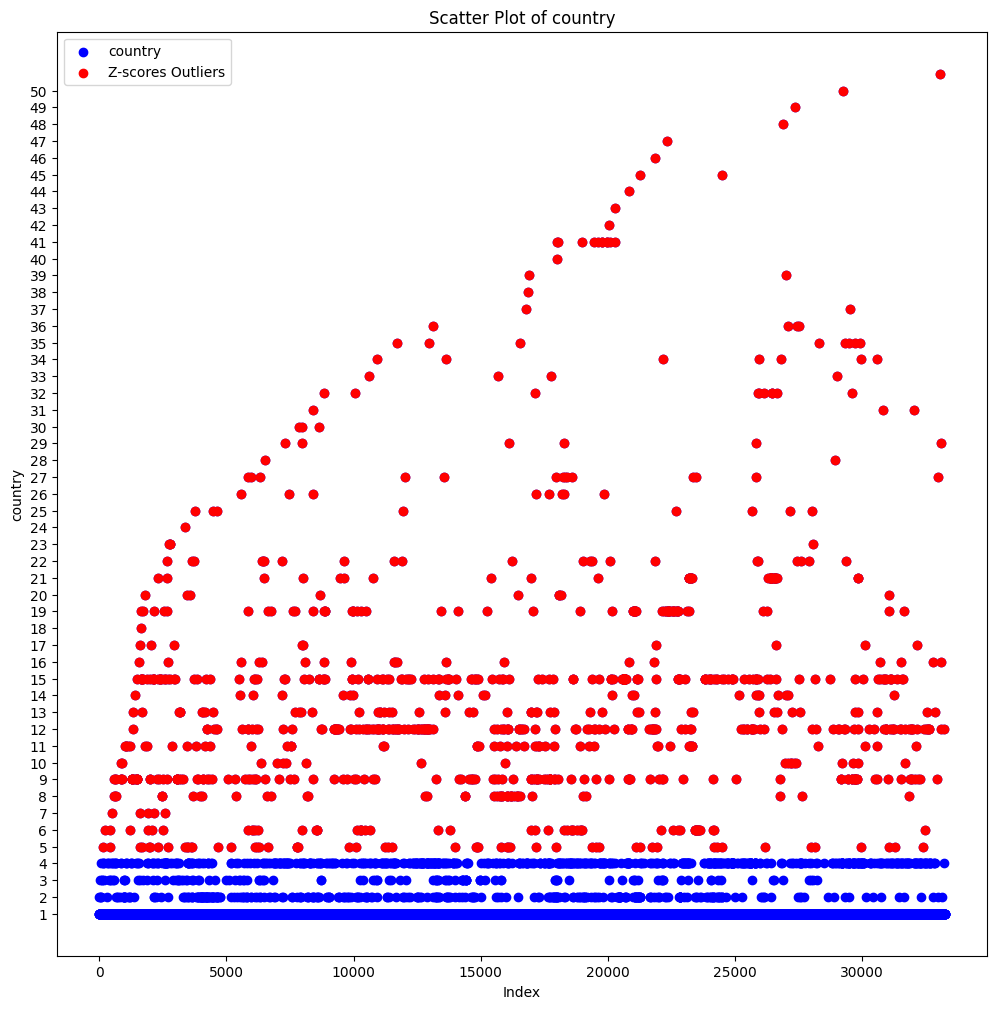

In [144]:
plt.figure(figsize=(12, 12))
plt.scatter(cleaned_df.index, cleaned_df['country'], color='blue', label='country')

# Scatter plot for outliers
plt.scatter(outliers_z.index, outliers_z['country'], color='red', label='Z-scores Outliers')
plt.title("Scatter Plot of country")
plt.xlabel("Index")
plt.ylabel("country")
plt.legend()

plt.yticks(range(1, 51))

plt.show()

In [147]:
country_counts = cleaned_df['country'].value_counts()

# Define the percentile threshold, e.g., 95th percentile
threshold_percentile = 99

# Calculate the threshold based on the percentile
threshold_value = country_counts.quantile(q=threshold_percentile / 100)

# Identify outliers based on the threshold
outliers_dist = country_counts[country_counts < threshold_value]


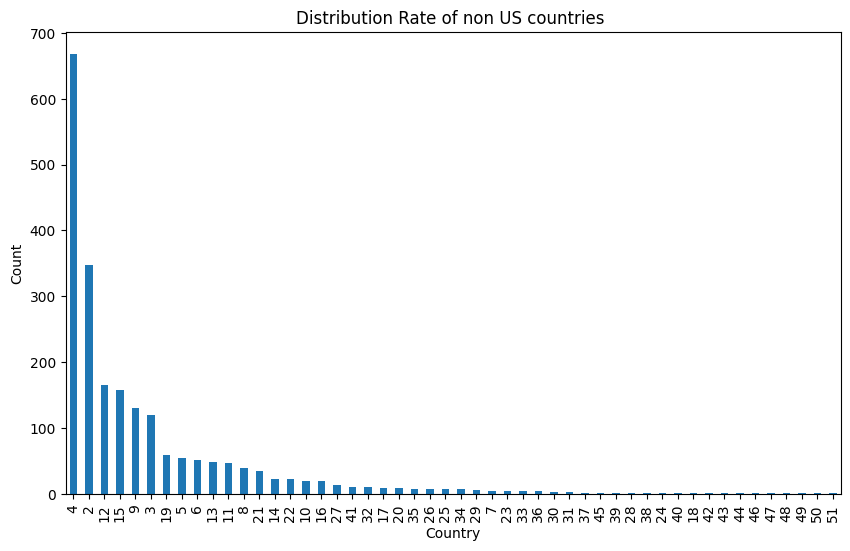

In [149]:
plt.figure(figsize=(10, 6))
outliers_dist.plot(kind='bar')
plt.title('Distribution Rate of non US countries ')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

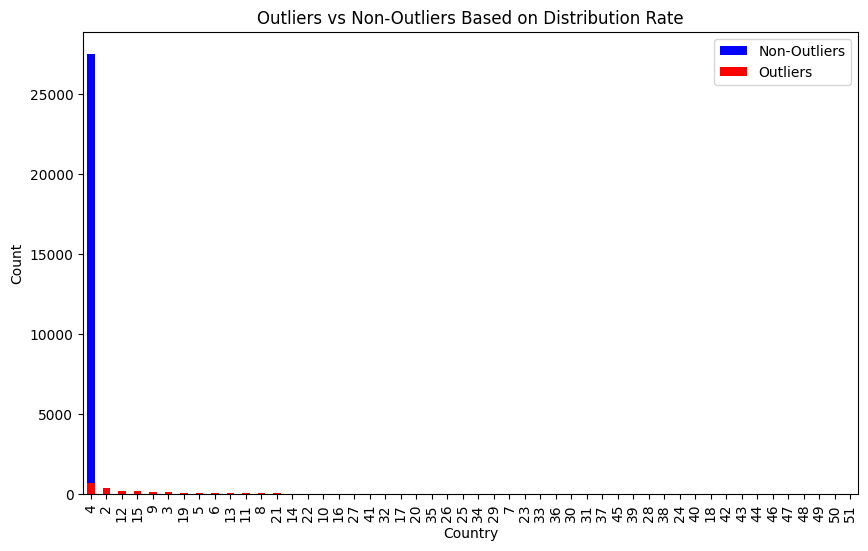

In [141]:
non_outliers = country_counts[country_counts >= threshold_value]

plt.figure(figsize=(10, 6))
non_outliers.plot(kind='bar', color='blue', label='Non-Outliers')
outliers_dist.plot(kind='bar', color='red', label='Outliers')
plt.title('Outliers vs Non-Outliers Based on Distribution Rate')
plt.xlabel('Country')
plt.ylabel('Count')
plt.legend()
plt.show()

### SMOTE Algorithm

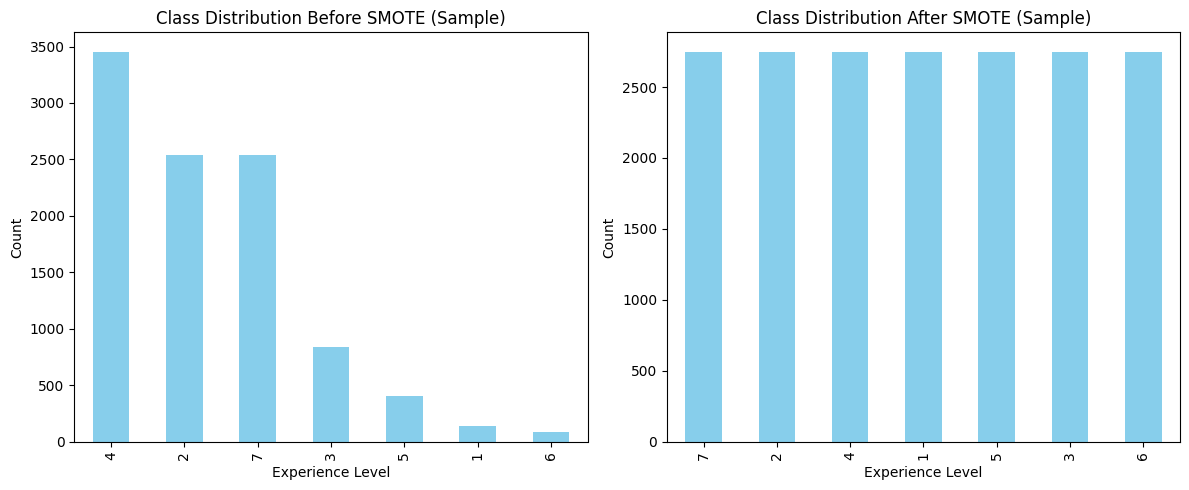

In [157]:
# Sample a subset of your data for faster visualization and testing
sample_size = 10000
df_sample = cleaned_df.sample(sample_size, random_state=42)

# Visualize class distribution before SMOTE for the sample
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_sample['experience_level'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution Before SMOTE (Sample)')
plt.xlabel('Experience Level')
plt.ylabel('Count')

# Prepare data for modeling
X_sample = pd.get_dummies(df_sample.drop(['experience_level'], axis=1))
y_sample = df_sample['experience_level']

# Handle NaN values using simple imputation
imputer = SimpleImputer(strategy='mean')  # You can use other strategies as needed
X_sample_imputed = pd.DataFrame(imputer.fit_transform(X_sample), columns=X_sample.columns)

# Determine the appropriate number of neighbors
n_neighbors = min(5, X_sample_imputed.shape[0] - 1)  # Set an appropriate maximum value
if n_neighbors >= X_sample_imputed.shape[0]:
    n_neighbors = X_sample_imputed.shape[0] - 1

# Split the sample dataset into training and testing sets
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_sample_imputed, y_sample, test_size=0.2, random_state=42
)

# Apply SMOTE to balance the sample dataset
smote = SMOTE(random_state=42, k_neighbors=min(n_neighbors, X_train_sample.shape[0] - 1))
X_train_resampled_sample, y_train_resampled_sample = smote.fit_resample(
    X_train_sample, y_train_sample
)

# Visualize class distribution after SMOTE for the sample
plt.subplot(1, 2, 2)
pd.Series(y_train_resampled_sample).value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution After SMOTE (Sample)')
plt.xlabel('Experience Level')
plt.ylabel('Count')

plt.tight_layout()
plt.show()